In [1]:
# Enable inline plotting (for Colab/Jupyter)
%matplotlib inline

# Imports — Standard Libraries
import os
import io
import glob
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.image as mpimg
import matplotlib
from PIL import Image, ImageDraw, ImageFont
from six import BytesIO
from scipy import misc

# Imports — TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# Imports — Scikit-learn
import sklearn.metrics

# Global Configuration
LEARNING_RATE = 0.0001
IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299

# Repository containing data or scripts
repo_url = 'https://github.com/adleberg/medical-ai'

# Convert a PIL image into a NumPy array. Ensures RGB format and returns a (height, width, 3) uint8 array.
def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# GitHub Repository Setup
%cd -q /content

# Clone repository
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet

# Navigate to repo directory
%cd -q {repo_dir_path}

# Pull latest changes
!git pull -q

# Install External Dependencies
!apt-get install -y graphviz
!pip install -q pydot

/tmp/ipython-input-2729149354.py:18: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [2]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [3]:
# Filter the dataset to separate images with 'Cardiomegaly' from normal cases
finding = "Cardiomegaly"
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
print(len(positives))

146


In [4]:
# Split the positive samples into training and testing sets
train_ratio = 0.8
test_ratio = 0.2
count = len(positives)
train_count = int(count * train_ratio)
test_count = int(count * test_ratio)
print("Training Samples: ", train_count, "\nTesting Samples: ", test_count)

Training Samples:  116 
Testing Samples:  29


In [5]:
# Create balanced training and testing label sets by combining positive and negative samples
train_labels = pd.concat([positives[:train_count], negatives[:train_count]])
test_labels = pd.concat([positives[train_count:], negatives[train_count:count]])

In [6]:
# Create directory structure for organizing training and testing images into positive and negative classes
rootdir = "/content/medical-ai/images/"
os.makedirs(rootdir + finding + "/test/positive",  exist_ok=True)
os.makedirs(rootdir + finding + "/test/negative",  exist_ok=True)
os.makedirs(rootdir + finding + "/train/positive", exist_ok=True)
os.makedirs(rootdir + finding + "/train/negative", exist_ok=True)


In [7]:
# Copy positive and negative images into their respective training and testing folders based on the defined split
for idx, image in positives[:train_count].iterrows():
    source = rootdir + image["filename"]
    dst = rootdir + finding + "/train/positive/" + image["filename"]
    shutil.copy(source, dst)

for idx, image in positives[train_count:].iterrows():
    source = rootdir + image["filename"]
    dst = rootdir + finding + "/test/positive/" + image["filename"]
    shutil.copy(source, dst)

for idx, image in negatives[:train_count].iterrows():
    source = rootdir + image["filename"]
    dst = rootdir + finding + "/train/negative/" + image["filename"]
    shutil.copy(source, dst)

for idx, image in negatives[train_count:count].iterrows():
    source = rootdir + image["filename"]
    dst = rootdir + finding + "/test/negative/" + image["filename"]
    shutil.copy(source, dst)

print("Done moving " + str(count * 2) + " images to positive and negative folders.")

Done moving 292 images to positive and negative folders.


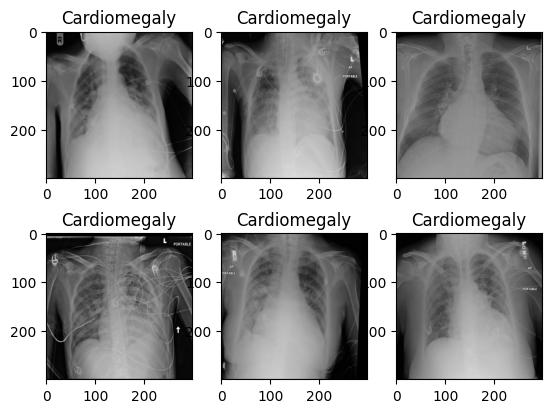

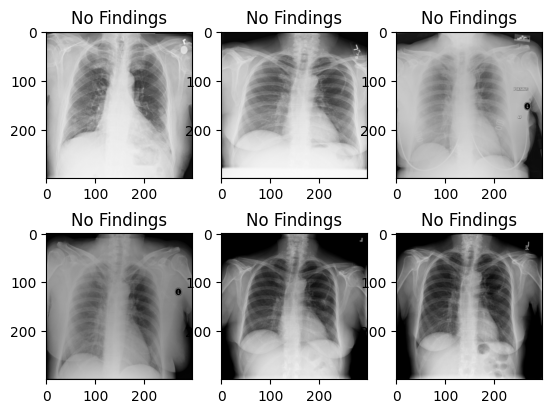

In [8]:
# Load and resize sample positive and negative images to visually compare the two classes
from PIL import Image, ImageDraw, ImageFont

positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299

for idx, row in positives[:6].iterrows():
    image_path = rootdir + row["filename"]
    image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
    image_path = rootdir + row["filename"]
    image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    negative_imgs.append(load_image_into_numpy_array(image))

for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])

plt.show()
